# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math
import random 

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# 1. Data Load  

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 2 columns x 5 picture**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [27]:
# original data : data 
path = "./Dataset/pic_dataset"

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

filenames = os.listdir(path)
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    categories.append(category)
#    if category == 'CN':
#        categories.append(0)
#    elif  category == 'MCI':
#        categories.append(1)
#    else:
#        categories.append(2)

data = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

data

,filename,category
0,CN_0.png,CN
1,CN_1.png,CN
2,CN_10.png,CN
3,CN_1000.png,CN
4,CN_1001.png,CN
...,...,...
9324,MCI_95.png,MCI
9325,MCI_96.png,MCI
9326,MCI_97.png,MCI
9327,MCI_98.png,MCI


# 2. EDA  

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터  
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 나눌 수 있겠습니다. 

**4. converting**
- CONVERT(activity_class_5min USING utf8)    
- CONVERT(activity_met_1min USING utf8)      
- CONVERT(sleep_hr_5min USING utf8)          
- CONVERT(sleep_hypnogram_5min USING utf8)  
- CONVERT(sleep_rmssd_5min USING utf8) 

**y variable**
- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9329 entries, 0 to 9328
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9329 non-null   object
 1   category  9329 non-null   object
dtypes: object(2)
memory usage: 145.9+ KB


# 3. Preprocessing 

**9,327 rows × 2 columns × 5 pictures**

|**===================Default 하게 진행======================**

CNN 모델에서는 converting feature를 png로 변환한 데이터를 사용할 예정 (이와 관련하여 create_pic_dataset.ipynb 참고할 것!)

**feature processing**
- astype : float 
- sig1_data, sig2_data, sig3_data, sig4_data, sig5_data 
    - CONVERT(activity_class_5min USING utf8)    
    - CONVERT(activity_met_1min USING utf8)      
    - CONVERT(sleep_hr_5min USING utf8)          
    - CONVERT(sleep_hypnogram_5min USING utf8)  
    - CONVERT(sleep_rmssd_5min USING utf8) 

**=========================Y Varible=========================**

- DIAG_NM 
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding 

In [29]:
# data를 따로 관리합니다 
# original data -> data 
# preprocessing data -> processed_data
processed_data = data.copy()

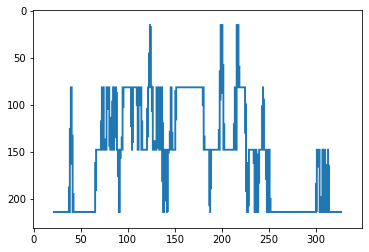

In [30]:
import tensorflow as tf

sample = random.choice(filenames)
image = tf.keras.preprocessing.image.load_img (path+"/"+sample)
plt.imshow(image)

# 4. Data Split 

train / valid / test data로 분할

- **ImageDataGenerator** 
    - CNN이 image data를 학습하기 위해서는 특별히 전처리를 진행해주어야 함 


In [35]:
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# data를 따로 관리
# preprocessing data -> processed_data
# train_data / valid_data / test_data 분할 
# 이 중 test_data -> test_X / test_y 로 한 번 더 분할

tr_val_data, test_data = train_test_split(processed_data, test_size=0.20, random_state=42)
train_data, valid_data = train_test_split(tr_val_data, test_size=0.20, random_state=42)

In [43]:
# parameter
batch_size=15

# image learning을 위한 preprocessing : ImageDataGenerator 
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_data, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    valid_data, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)

Found 5969 validated image filenames belonging to 3 classes.
Found 1493 validated image filenames belonging to 3 classes.


# 5. Modeling - DL 

- **CNN**
    - https://dataplay.tistory.com/37?category=845492
   

In [52]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score

In [53]:
# parameters
earlystop = EarlyStopping(patience=30)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

total_train = train_data.shape[0]
total_valid = valid_data.shape[0]

In [54]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, 3, activation='relu', padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(48, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, 3, activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 48)        13872     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        27712     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 64)       

In [55]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
398/398 [==============================] - 75s 186ms/step - loss: 0.9661 - accuracy: 0.6235 - val_loss: 0.8654 - val_accuracy: 0.6337
Epoch 2/50
398/398 [==============================] - 73s 184ms/step - loss: 0.8270 - accuracy: 0.6489 - val_loss: 0.8415 - val_accuracy: 0.6337
Epoch 3/50
398/398 [==============================] - 73s 184ms/step - loss: 0.8304 - accuracy: 0.6391 - val_loss: 0.8300 - val_accuracy: 0.6343
Epoch 4/50
398/398 [==============================] - 71s 178ms/step - loss: 0.8218 - accuracy: 0.6395 - val_loss: 0.8082 - val_accuracy: 0.6350
Epoch 5/50
398/398 [==============================] - 73s 184ms/step - loss: 0.7825 - accuracy: 0.6426 - val_loss: 0.8193 - val_accuracy: 0.6337
Epoch 6/50
398/398 [==============================] - 71s 179ms/step - loss: 0.7863 - accuracy: 0.6431 - val_loss: 0.7995 - val_accuracy: 0.6343
Epoch 7/50
398/398 [==============================] - 71s 177ms/step - loss: 0.7825 - accuracy: 0.6461 - val_loss: 0.7862 - val_ac

Epoch 28/50
398/398 [==============================] - 91s 227ms/step - loss: 0.7835 - accuracy: 0.6439 - val_loss: 0.7978 - val_accuracy: 0.6512
Epoch 29/50
398/398 [==============================] - 90s 226ms/step - loss: 0.7652 - accuracy: 0.6596 - val_loss: 0.7765 - val_accuracy: 0.6492
Epoch 30/50
398/398 [==============================] - 89s 224ms/step - loss: 0.7565 - accuracy: 0.6595 - val_loss: 0.7885 - val_accuracy: 0.6377
Epoch 31/50
398/398 [==============================] - 91s 227ms/step - loss: 0.7663 - accuracy: 0.6699 - val_loss: 0.7978 - val_accuracy: 0.6337
Epoch 32/50
398/398 [==============================] - 90s 226ms/step - loss: 0.7842 - accuracy: 0.6517 - val_loss: 0.7683 - val_accuracy: 0.6519
Epoch 33/50
398/398 [==============================] - 90s 225ms/step - loss: 0.7720 - accuracy: 0.6643 - val_loss: 0.7772 - val_accuracy: 0.6465
Epoch 34/50
398/398 [==============================] - 90s 226ms/step - loss: 0.7641 - accuracy: 0.6552 - val_loss: 0.7688 -

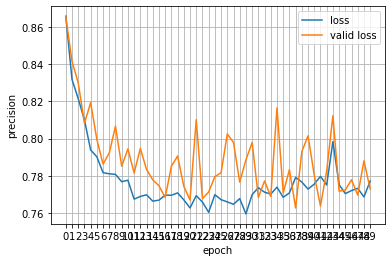

In [56]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.xticks(range(len(history.history['loss'])))
plt.xlabel('epoch')
plt.ylabel('precision')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [57]:
pred_cnn = model.predict(test_data)

ValueError: in user code:

    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Hyeongbin\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_3 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 2)
